In [8]:
from dask_jobqueue import SLURMCluster

cluster = SLURMCluster(
    job_name="Climt1",          # --job-name
    cores=12,                     # Number of cores per task (adjust if needed)
    processes=6,                 # One process per task
    memory="100GB",               # --mem
    walltime="01:15:00",         # --time
    queue="med",               # --partition
    log_directory=".",           # Logs will be saved to the current directory
)


/home1/nalex2023/.conda/envs/nma/lib/python3.13/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 44905 instead
  warnings.warn(


In [11]:
from dask.distributed import Client


cluster.scale(jobs=10)
client = Client(cluster)

In [12]:
client

Connection method: Cluster object,Cluster type: dask_jobqueue.SLURMCluster
Dashboard: http://10.42.239.61:44905/status,
Dashboard: http://10.42.239.61:44905/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.42.239.61:41185,Workers: 0
Dashboard: http://10.42.239.61:44905/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [10]:
import xarray as xr
import numpy as np
import glob
import pandas as pd
import os


In [16]:
#test_dset =  xr.open_dataset('Datasets/met_manus_yr/1997-2000.met_manus.nc')

def create_dft(in_dir,arm_data=True):
    files = glob.glob(in_dir+os.sep+'*.nc')
    if len(files) == 0:
        files = glob.glob(in_dir+os.sep+'*.cdf')
        if len(files) == 0:
            raise Exception('No files Found')
        else:
            pass
    else:
        pass
    
    dft = pd.DataFrame(files,columns=['filepath'])
    dft['filename'] = dft['filepath'].str.split(os.sep).str[-1]
    
    if arm_data:
        dft['datetime'] = pd.to_datetime(dft['filename'].str.split(
            '.',
            expand=True).iloc[:, 2] + dft['filename'].str.split(
                '.',  expand=True).iloc[:, 3],format='%Y%m%d%H%M%S')
    return dft


files_met = 'Datasets/met_manus/'

dft_met = create_dft(files_met).set_index('datetime').sort_index()

years = [2001]

dft_sub = dft_met.loc[str(years[0]):str(years[-1])]


dft_sub

,filepath,filename
datetime,,
2001-01-01 00:00:01,Datasets/met_manus/twpmetC1.b1.20010101.000001...,twpmetC1.b1.20010101.000001.cdf
2001-01-02 00:00:00,Datasets/met_manus/twpmetC1.b1.20010102.000000...,twpmetC1.b1.20010102.000000.cdf
2001-01-03 00:00:01,Datasets/met_manus/twpmetC1.b1.20010103.000001...,twpmetC1.b1.20010103.000001.cdf
2001-01-04 00:00:00,Datasets/met_manus/twpmetC1.b1.20010104.000000...,twpmetC1.b1.20010104.000000.cdf
2001-01-05 00:00:00,Datasets/met_manus/twpmetC1.b1.20010105.000000...,twpmetC1.b1.20010105.000000.cdf
...,...,...
2001-12-27 00:00:00,Datasets/met_manus/twpmetC1.b1.20011227.000000...,twpmetC1.b1.20011227.000000.cdf
2001-12-28 00:00:00,Datasets/met_manus/twpmetC1.b1.20011228.000000...,twpmetC1.b1.20011228.000000.cdf
2001-12-29 00:00:00,Datasets/met_manus/twpmetC1.b1.20011229.000000...,twpmetC1.b1.20011229.000000.cdf


In [ ]:
all_dset = xr.open_mfdataset(dft_sub['filepath'].values,combine='by_coords',
                             chunks={})

all_dset['time'] = all_dset['time'] + pd.to_timedelta(10,'h')


In [29]:
all_dset

<xarray.Dataset> Size: 138MB
Dimensions:                  (time: 521090)
Coordinates:
  * time                     (time) datetime64[ns] 4MB 2001-01-01T10:00:01 .....
Data variables: (12/45)
    base_time                (time) datetime64[ns] 4MB dask.array<chunksize=(1440,), meta=np.ndarray>
    time_offset              (time) datetime64[ns] 4MB dask.array<chunksize=(1440,), meta=np.ndarray>
    atmos_pressure           (time) float32 2MB dask.array<chunksize=(1440,), meta=np.ndarray>
    qc_atmos_pressure        (time) float64 4MB dask.array<chunksize=(1440,), meta=np.ndarray>
    temp_mean                (time) float32 2MB dask.array<chunksize=(1440,), meta=np.ndarray>
    qc_temp_mean             (time) float64 4MB dask.array<chunksize=(1440,), meta=np.ndarray>
    ...                       ...
    qc_logger_volt           (time) float64 4MB dask.array<chunksize=(1440,), meta=np.ndarray>
    logger_temp              (time) float32 2MB dask.array<chunksize=(1440,), meta=np.ndarray>
    qc_logger_temp           (time) float64 4MB dask.array<chunksize=(1440,), meta=np.ndarray>
    lat                      (time) float32 2MB dask.array<chunksize=(1440,), meta=np.ndarray>
    lon                      (time) float32 2MB dask.array<chunksize=(1440,), meta=np.ndarray>
    alt                      (time) float32 2MB dask.array<chunksize=(1440,), meta=np.ndarray>
Attributes: (12/30)
    command_line:                met_ingest -s twp -f C1 -R -D
    process_version:             ingest-met-4.28-0.el6
    dod_version:                 met-b1-8.1
    input_source:                /data/home/gervais/prod/jobs/0742/collection...
    site_id:                     twp
    platform_id:                 met
    ...                          ...
    qc_bit_2_assessment:         Bad
    qc_bit_3_description:        Value is greater than the valid_max.
    qc_bit_3_assessment:         Bad
    qc_bit_4_description:        Difference between current and previous valu...
    qc_bit_4_assessment:         Indeterminate
    history:                     created by user gervais on machine amber at ...

In [43]:

# remove values greater than 50

all_dset = all_dset.where(all_dset['qc_temp_mean'] == 0)

all_dset = all_dset.where(all_dset['qc_rh_mean'] == 0)


all_dset = all_dset.where(all_dset['qc_wspd_arith_mean'] == 0)

all_dset = all_dset.where(all_dset['qc_wdir_vec_mean'] == 0)


all_dset_diurnal = all_dset.groupby('time.hour').mean()


In [49]:
computed_dset = all_dset_diurnal.compute()

KeyboardInterrupt: 

In [ ]:

computed_dset

TypeError: len() of unsized object

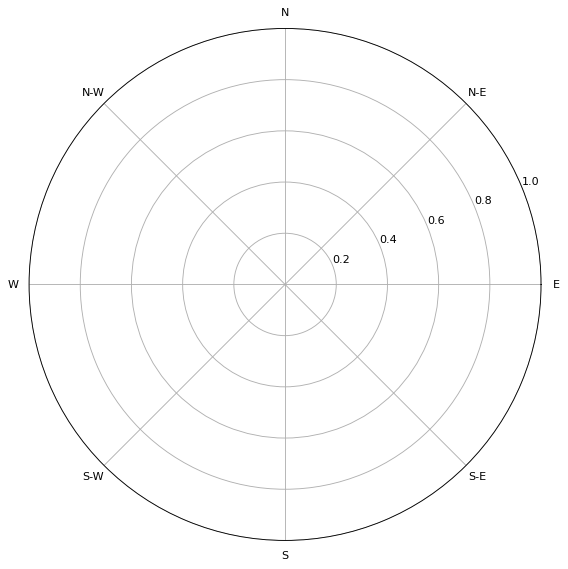

In [48]:
from windrose import WindroseAxes


ax = WindroseAxes.from_ax()

wspd = all_dset_diurnal['wspd_arith_mean'].sel(hour=15).values

wdir = all_dset_diurnal['wdir_vec_mean'].sel(hour=15).values


ax.bar(wdir, wspd, normed=True, opening=0.8, edgecolor='white')

#all_dset_diurnal['wdir_vec_mean'].plot.line(x='hour')





In [22]:
from dask.diagnostics import ProgressBar
import dask 

def prepro(ds):
    list_vars = ['wdir_vec_mean', 'wspd_vec_mean', 'rh_mean', 'temp_mean']
    ds_sub = ds[list_vars]
    ds_re = ds_sub.resample(time='1H').mean()
    return ds_re


years = [year for year in dft_met.index.year.unique()]

years

save_tasks = [] 
for ii in years:
    dft_sub = (dft_met[dft_met.index.year == ii]).sort_index()
    dset = xr.open_mfdataset(dft_sub['filepath'].values,preprocess=prepro,parallel=True,chunks={},combine='by_coords')
    out_fol = f'Datasets/met_manus_yr/met_manus_{ii}.nc'

    save_tasks.append(dset.to_netcdf(out_fol,compute=False))
    #dset.to_netcdf(out_fol)

with ProgressBar():
    results = dask.compute(*save_tasks)

ValueError: Resulting object does not have monotonic global indexes along dimension time

In [50]:
client.close()

cluster.close()